
#**Feature extraction**

What this script does:
- find training and test raw audio data
- extract mfcc spectrogram features from each file
- save these to pickle files
- allows for checking of these by reloading them in

This means feature sets can be saved as pickle file, so they don't haev to be recalculated each tim tinkering with the model training script is performed



In [ ]:
# Connect GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import datetime
import numpy as np
import random
import os
import pickle

# progress tracker for feature extraction
from tqdm import tqdm 

 # for audio processing
import librosa
import librosa.display # used for spec viewing

# view spectrograms of some example files
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# where the audio is saved
train_dir = "/content/drive/MyDrive/bombs/data/final_dataset/train_data/" #make sure ends in '/'
test_dir = "/content/drive/MyDrive/bombs/data/final_dataset/test_data/"
pickle_file_dir = "/content/drive/MyDrive/bombs/data/final_dataset/"

sample_rate = 8000

# set seed
import random
seed = 123
np.random.seed(123)

In [ ]:
# added for TF tutorial

import seaborn as sns


import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tempfile



# for metric plots later on
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# View spectrograms

View some mel spectrograms (not mfcc specs) of the data to check it looks correct




In [ ]:
def view_mel_spec(filename, sr):
  """"Creates a spectrogram plot of an audio file in the mel scale (this 
  emphasises lower frequencies). If audio_dir is set, pass in the filename as 
  a string and sample rate as an integer"""
  
  #set hop lenght for mel_spec and.specshow()
  hop_length = 64

  # read in the audio file
  file_path = train_dir + filename
  audio, sample_rate = librosa.load(file_path, sr = sr)

  # compute the mel spectrogram of the audio
  mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128,
                                            win_length=1024, hop_length=hop_length)

  # convert the power spectrogram to decibel (dB) units 
  mel_spec_db = librosa.power_to_db(S=mel_spec, ref=1.0) 

  #### plot the spectrogram
  plt.figure(figsize=(5, 5))
  librosa.display.specshow(mel_spec_db, sr=sample_rate,  
                           y_axis='mel', x_axis='time',  
                           vmin = -100, vmax = 0, 
                           cmap = 'magma', hop_length=hop_length)
  plt.colorbar()

  # Set y-axis
  plt.yticks([200, 500, 1000, 2000, 4000])
  plt.ylim(0,4000)

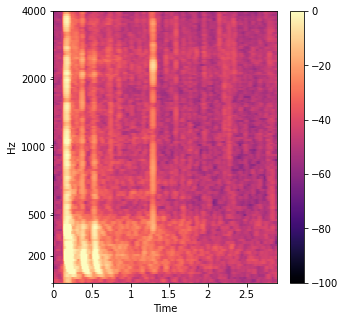

In [ ]:
# view a non bomb file
view_mel_spec('YB00001_M01_20220830_060000.wav', sample_rate)

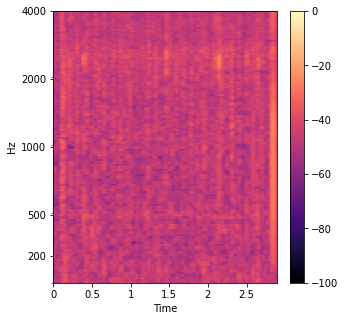

In [ ]:
# view a non bomb file
view_mel_spec('NB00002_M13_20220917_215000.WAV', sample_rate)

# Extract features

Main code section used for extracting mel spectrogram features

WARNING - if expanding to very large datasets this could cause out of memory errors as all features are appended to arrays which are held in memory. Could fix by e.g saving to seperate pickle files or tf.data objects?

In [ ]:
def extract_features_labels(dataset, audio_dir):

  # create empty lists
  feature_list = []
  label_list = []

  # Extract mel spec from all files
  for file in tqdm(dataset):
      # Load audio
      audio_path = os.path.join(audio_dir, file)
      audio, sr = librosa.load(path=audio_path, sr=sample_rate)

      # Calculate MFCC
      mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=32)

      # convert the power spectrogram to decibel (dB) units 
      #mel_spec_db = librosa.power_to_db(S=mel_spec, ref=1.0) 

      # define new shape
      shape = np.shape(mfcc)
      input_shape = tuple(list(shape) + [1])
      #print(add_colour_channel) # uncomment to view shape

      # set new shape and append to list - NOTE, if working with large dataset suspect may cause OOM error
      feature_list.append(np.reshape(mfcc, input_shape))

      # Get label from first character of file name and append to list
      if file[0:2] == 'NB':
        label_list.append([0]) # note must be in sq bracket
      if file[0:2] == 'YB': 
        label_list.append([1]) # note must be in sq bracket        

  # convert to numpy arrays which can be input into the network
  features = np.array(feature_list)
  labels = np.array(label_list)

  return features, labels, input_shape

In [ ]:
# Make list of all the audio files in the directory
train_files = [f for f in os.listdir(train_dir) if f.endswith('.wav') or f.endswith('.WAV')]
train_file_count = len(train_files)
print(f"found {train_file_count} training files".format(train_file_count))

# shuffle list of files so files from same sites get shuffled around
shuffle(train_files)

# extract features and labels, plus save input shape for network
train_features, train_labels, input_shape = extract_features_labels(train_files, train_dir)


# print index of bombs
print()
print('Input shape for network: ' + str(input_shape))
print()
print('Index of bomb files: ' + str((np.where(train_labels == 1))[0]))


# save the outputs to pickle file
pickle_file = "train_features_labels.pickle"
pickle_file_path = os.path.join(pickle_file_dir, pickle_file)

# Save the object to pickle file
with open(pickle_file_path, 'wb') as f:
    pickle.dump((train_features, train_labels, input_shape), f)

found 18780 training files


100%|██████████| 18780/18780 [46:13<00:00,  6.77it/s]



Input shape for network: (32, 46, 1)

Index of bomb files: [    8    10    17 ... 18754 18763 18770]


In [ ]:
# list all the audio files in the directory
test_files = [f for f in os.listdir(test_dir) if f.endswith('.wav') or f.endswith('.WAV')]
test_file_count = len(test_files)
print(f"found {test_file_count} test files".format(test_file_count))

# set the order of the test files (sometimes it comes out jumbled). Start with NB files, with lowest numbers first
def custom_sort_key(string):
    if string.startswith('NB'):
        return (0, int(string[2:7]))
    elif string.startswith('YB'):
        return (1, int(string[2:7]))
    else:
        raise ValueError(f"Unexpected string format: {string}")

sorted_test_files = sorted(test_files, key=custom_sort_key)

# extract features and labels, plus save input shape for network
test_features, test_labels, input_shape = extract_features_labels(sorted_test_files, test_dir)

# print index of bombs
print()
print('Input shape for network: ' + str(input_shape))
#print()
print('Index of bomb files: ' + str((np.where(test_labels == 1))[0]))

# save the outputs to pickle file
pickle_file = "test_features_labels.pickle"
pickle_file_path = os.path.join(pickle_file_dir, pickle_file)

# Save the object to pickle file
with open(pickle_file_path, 'wb') as f:
    pickle.dump((test_features, test_labels, input_shape), f)

found 1250 test files


100%|██████████| 1250/1250 [02:29<00:00,  8.34it/s]


Input shape for network: (32, 46, 1)
Index of bomb files: [1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013
 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027
 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041
 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055
 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069
 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083
 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097
 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 1111
 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125
 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139
 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153
 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167
 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181
 1182 1183 1184 11

# Check pickle files

Once pickle files are saved, these can be cheacked by reading these in. You can check the length, shape etc. Also view some example mfcc specs in the next section.

In [ ]:
pickle_file_name = "train_features_labels.pickle"
pickle_file_path = os.path.join(pickle_file_dir, pickle_file_name)

# Load the pickle file
with open(pickle_file_path, 'rb') as f:
    train_features, train_labels, input_shape = pickle.load(f)

In [ ]:
pickle_file_name = "test_features_labels.pickle"
pickle_file_path = os.path.join(pickle_file_dir, pickle_file_name)

# Load the pickle file
with open(pickle_file_path, 'rb') as f:
    test_features, test_labels, input_shape = pickle.load(f)

# View some example mfcc's

Select from list above which shows the index of each bomb file to view bombs or normal data

In [ ]:
def plot_mfcc(chosen_file):
    # Drop the extra channel added for the network
    spec_data = train_features[chosen_file][:, :, 0]

    # Create a figure with specified width and height
    fig = plt.figure(figsize=(8,5))

    # Add subplot to the figure
    ax = fig.add_subplot(111)

    # Plot the data
    cax = ax.imshow(spec_data, interpolation='nearest', cmap='magma', origin='lower', vmin=-100, vmax=0.0,)
    ax.set_title('Mel spec')

    # Set aspect ratio to the aspect ratio of the data
    aspect = spec_data.shape[1] / spec_data.shape[0]
    ax.set_aspect(aspect)

    plt.show()

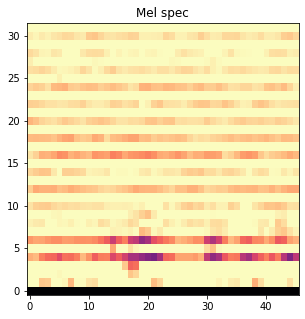

In [ ]:
plot_mfcc(3)

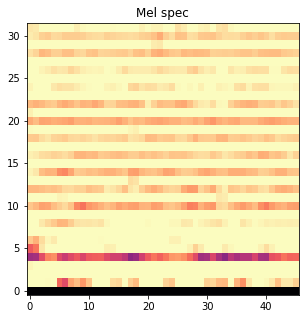

In [ ]:
plot_mfcc(0)